<a href="https://www.kaggle.com/code/mukuldev007/traffic-segmentation?scriptVersionId=134217008" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  **Introduction**
This project is a custom U-NET model. It performs semantic segmentation on vehicle image driven on roads. The dataset used is [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs).
This project takes heavy inspiration from Andrew NG's Deep Learning Course from where I learned about U-NET and Deep Learning Concepts in general. I am a beginner, and this is my first proper project on Kaggle. Hope you like it.

# **Importing Modules**
Project has been built using Tensorflow, and hence all required layers are imported.
To manipulate images and make graphs, matplotlib and cv2 are imported.

In [10]:
#!pip install tensorflow
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

# **Definitions**
Some variables and functions are defined.

In [11]:
#Defining variables here, they will be used a lot and can be changed in future
TRAIN_PATH = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/"
VAL_PATH = "/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/"
CHECKPOINT_PATH = "/kaggle/working/checkpoint.ckpt"
MODEL_PATH = "/kaggle/working/saved_model.h5"
SIZE = (256,256,3)
N_CLASSES = 35
FILTERS = 32
KERNEL = 3

The code below is from [mohomran](https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55). It contains information about the classes in the dataset. **Id2Color** is a dictionary whose key is label id and value is its color in form of numpy array. 

In [12]:
#info from https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55
#!/usr/bin/python
#
# Cityscapes labels
#

from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

Id2Color = { label.id : np.asarray(label.color) for label in labels }

I have mask for an image, where different color represents different classes, but dealing with color is difficult. It is far easier if I can determine instead of color, what is the class of a particular pixel. For each mask, I need to know what pixel belongs to what class. For example, if a car is present, all pixels in the car belong to class car and would have id as 26 (see Label). Hence, I will give a mask which is of **shape(256x256x3)** (depth dimension for color) and recieve an array of **shape(256x256)** where each pixel will contains values from 0 to NUM_CLASSES -1 ,i.e, a single class.

There are many methods to do this like KMean. But I decided to do this in a simple way. I decided to choose the label, which were the closest distance (pixel wise) to our chosen pixel. Distance between two pixels can be said as the square root of norm between their difference.

First a **distance** array and **category** array is initialized. Category is our output and distance stores distances of each pixel with their category (we have to minimize this). Initialy distance should be infinte.
For each item in **Id2Color**, I find the distance of every pixel in mask with label pixels and store in an array dist. Then I need to find values in distance which are larger, these can be replaced with smaller values,i.e., dist. This can be done using boolean masking and using np.where().

In [13]:
def FindLabels(mask, mapping):
    distance = np.full([mask.shape[0], mask.shape[1]], 99999) 
    category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items():
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        condition = distance > dist
        distance = np.where(condition, dist, distance)
        category = np.where(condition, id, category)
    
    return category

# **Dataset**
Time to convert the dataset. Images are preprocesed. They are first split into two parts, the non-mask and masked parts. Non-masked images are stored in array X. For the mask, although I need only the encoded part (the one on which label is put), but I take both labelled and unlabelled mask so that I can compare them both.

In [14]:
def pre_process_images(num_images,path):
    X = np.empty((num_images ,SIZE[0] ,SIZE[1] ,SIZE[2]), dtype=np.uint8)
    Y_mask = np.empty((num_images ,SIZE[0] ,SIZE[1] ,SIZE[2]), dtype=np.uint8)
    Y_mask_enc = np.empty((num_images ,SIZE[0] ,SIZE[1]), dtype=np.uint8)
    
    for i, image in enumerate(os.listdir(path)):
        img = cv2.imread(os.path.join(path,image))
        
        X[i] = img[:,:256,:]
        Y_mask[i] = img[:,256:,:]
        Y_mask_enc[i] = FindLabels(Y_mask[i] , Id2Color)

    print(X.shape)
    print(Y_mask.shape)
    print(Y_mask_enc.shape)
    
    return X,Y_mask,Y_mask_enc


In [15]:
X_train, Y_train,Y_train_enc = pre_process_images(2975,TRAIN_PATH)
X_val, Y_val, Y_val_enc = pre_process_images(500,VAL_PATH)

(2975, 256, 256, 3)
(2975, 256, 256, 3)
(2975, 256, 256)
(500, 256, 256, 3)
(500, 256, 256, 3)
(500, 256, 256)


The function below converts the mask with labels back to images by using Id2Color to map back label_id to its color.

In [16]:
def color_enc_mask(mask_enc, mapping):
    color_enc = np.zeros(SIZE)
    for i in range(SIZE[0]):
        for j in range(SIZE[1]):
            color_enc[i,j,:] = mapping[mask_enc[i,j]]
            color_enc = color_enc.astype('uint8')
    return color_enc

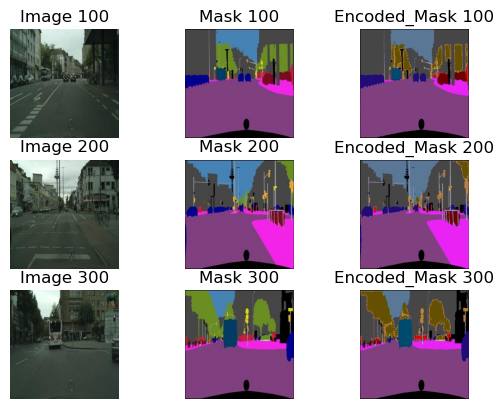

In [17]:
#Comparing training images with masks and encoded masks
height = 3
for i in range(0,height):
    n = 100*(i+1)
    plt.subplot(height, 3, 3*i+1)
    plt.imshow(cv2.cvtColor(X_train[n], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(n)))
    
    plt.subplot(height, 3, 3*i+2)
    plt.imshow(cv2.cvtColor(Y_train[n], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Mask {}'.format(str(n)))
    
    plt.subplot(height, 3, 3*i+3)
    plt.imshow(cv2.cvtColor(color_enc_mask(Y_train_enc[n],Id2Color), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Encoded_Mask {}'.format(str(n)))

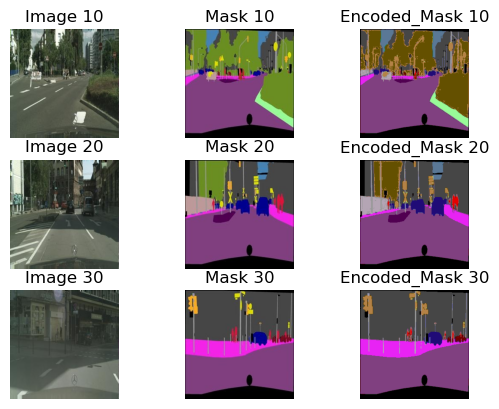

In [18]:
#Comparing validation images with masks and encoded masks
height = 3
for i in range(0,height):
    n = 10*(i+1)
    plt.subplot(height, 3, 3*i+1)
    plt.imshow(cv2.cvtColor(X_val[n], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(n)))
    
    plt.subplot(height, 3, 3*i+2)
    plt.imshow(cv2.cvtColor(Y_val[n], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Mask {}'.format(str(n)))
    
    plt.subplot(height, 3, 3*i+3)
    plt.imshow(cv2.cvtColor(color_enc_mask(Y_val_enc[n],Id2Color), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Encoded_Mask {}'.format(str(n)))

As we can see, not the best results, but they are ok. I will look for better ways to label them in future.

# **Model Making**
U-Net is a convolutional neural network that was designed for medical image segmentation at Computer Science Department of the University of Freiburg. Because of its good results, it was also used in other fields.
It is named as such because of its shape which resembles the english alphabet 'U' . It has Down-Sampling region (Contracting Path) and Upper-Sampling region (Expansive Path). The down-sampling region reduces the spatial information but increases the number of channels. The up-sampling region increases spatial information and decreases channels. U-Net also utilizes skip-connections between these two paths.

In [19]:
def down_sampling_block(prev_layer,filters,maxPool=True,drop_prob=0):
    conv = Conv2D(filters=filters,
                  kernel_size=KERNEL,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(prev_layer)
    
    conv = Conv2D(filters=filters,
                  kernel_size=KERNEL,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    if drop_prob > 0:
        conv = Dropout(drop_prob)(conv)
        
    if maxPool:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer,skip_connection

In [20]:
def up_sampling_block(skip_connection,prev_layer,filters):
    upper = Conv2DTranspose(filters=filters,
                            kernel_size=KERNEL,
                            strides=(2,2),
                            padding='same')(prev_layer)
    conc = concatenate([upper,skip_connection],axis=3)
    
    conv = Conv2D(filters=filters,
                  kernel_size=KERNEL,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conc)
    conv = Conv2D(filters=filters,
                  kernel_size=KERNEL,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    return conv

In [21]:
def U_Net_Model(filters,size,classes=N_CLASSES):
    #Input layer
    d0 = Input(size)
    
    #Downsampling Region
    d1, d1_skip = down_sampling_block(d0,filters)
    d2, d2_skip = down_sampling_block(d1,filters*2)
    d3, d3_skip = down_sampling_block(d2,filters*4)
    d4, d4_skip = down_sampling_block(d3,filters*8,drop_prob = 0.1)
    d5, d5_skip = down_sampling_block(d4,filters*16,drop_prob = 0.3)
    
    #Bottleneck
    b0, _ = down_sampling_block(d5,filters*32,maxPool = False,drop_prob = 0.3)
    
    #Upsampling Region
    u5 = up_sampling_block(d5_skip,b0,filters*16)
    u4 = up_sampling_block(d4_skip,u5,filters*8)
    u3 = up_sampling_block(d3_skip,u4,filters*4)
    u2 = up_sampling_block(d2_skip,u3,filters*2)
    u1 = up_sampling_block(d1_skip,u2,filters)
    
    #Output Layer
    u0 = Conv2D(filters=filters,
                kernel_size=KERNEL,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(u1)
    u0 = Conv2D(classes,kernel_size=1 , padding='same')(u0)
    
    model = tf.keras.Model(inputs=d0, outputs=u0)

    return model

In [22]:
#Free some memory
del Y_train, Y_val

X_train = np.stack(X_train).astype('float32') / 255.0
Y_train_enc = np.stack(Y_train_enc).astype('float32')

X_val = np.stack(X_val).astype('float32') / 255.0
Y_val_enc = np.stack(Y_val_enc).astype('float32')

In [23]:
UNet = U_Net_Model(filters=FILTERS, size=SIZE, classes=N_CLASSES)
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [24]:
UNet.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(CHECKPOINT_PATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

In [25]:
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 1 

model_history = UNet.fit(x = X_train, y = Y_train_enc,
                         epochs = EPOCHS,batch_size = BATCH_SIZE,
                         verbose = VERBOSE,
                         validation_data = (X_val,Y_val_enc),
                         shuffle = True, use_multiprocessing = True,
                         callbacks=[model_checkpoint])

Epoch 1/50


2023-06-20 05:31:02.997541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - ETA: 0s - loss: 38.1092 - accuracy: 0.1762
Epoch 1: val_accuracy improved from -inf to 0.13798, saving model to /kaggle/working/checkpoint.ckpt
47/47 [==============================] - 183s 3s/step - loss: 38.1092 - accuracy: 0.1762 - val_loss: 2.7936 - val_accuracy: 0.1380
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 2.1295 - accuracy: 0.4942
Epoch 2: val_accuracy improved from 0.13798 to 0.57735, saving model to /kaggle/working/checkpoint.ckpt
47/47 [==============================] - 99s 2s/step - loss: 2.1295 - accuracy: 0.4942 - val_loss: 1.7234 - val_accuracy: 0.5773
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 1.5009 - accuracy: 0.6122
Epoch 3: val_accuracy improved from 0.57735 to 0.62176, saving model to /kaggle/working/checkpoint.ckpt
47/47 [==============================] - 92s 2s/step - loss: 1.5009 - accuracy: 0.6122 - val_loss: 1.4340 - val_accuracy: 0.6218
Epoch 4/50
47/47 [============

In [26]:
UNet.save(MODEL_PATH)

# **Performance**

In [27]:
val_loss, val_accuracy = UNet.evaluate(x = X_val, y = Y_val_enc)

print('\n\033[1m' + 'The model has an accuracy of {}%!!'.format(round(100*val_accuracy, 3)) + '\033[0m')

16/16 [==============================] - 17s 599ms/step - loss: 0.7117 - accuracy: 0.8159

The model has an accuracy of 81.588%!!


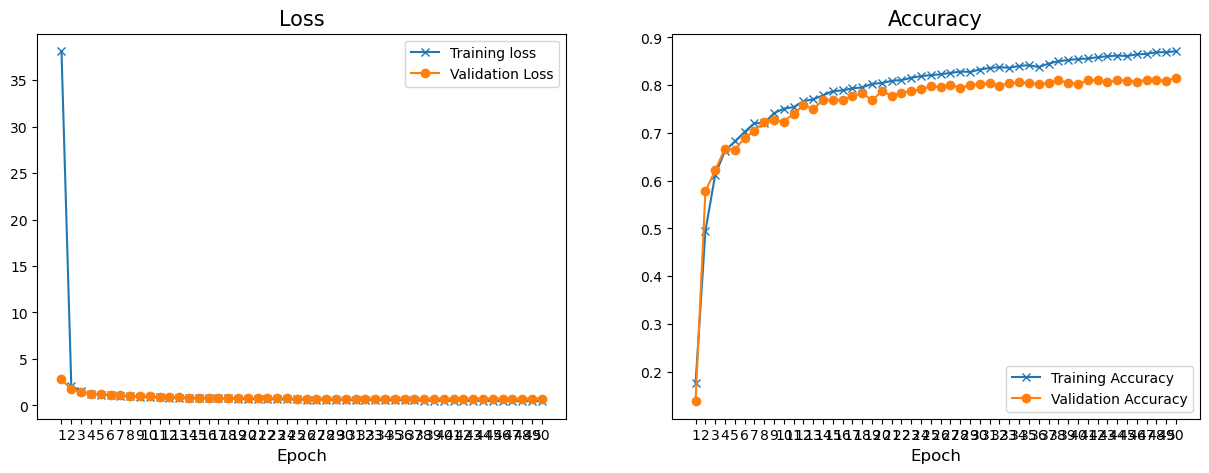

In [28]:
_ , (LossPlot, AccuracyPlot) = plt.subplots(1,2, figsize=(15,5))

#Training and Validation Loss Curves
LossPlot.plot(range(1, EPOCHS + 1), model_history.history['loss'], marker='x', label='Training loss')
LossPlot.plot(range(1, EPOCHS + 1), model_history.history['val_loss'], marker='o', label='Validation Loss')
LossPlot.set_xticks(range(1, EPOCHS + 1))
LossPlot.set_title('Loss', fontsize=15)
LossPlot.set_xlabel('Epoch', fontsize=12)
LossPlot.legend()

#Training and Validation Accuracy Curves
AccuracyPlot.plot(range(1, EPOCHS + 1), model_history.history['accuracy'], marker='x', label='Training Accuracy')
AccuracyPlot.plot(range(1, EPOCHS + 1), model_history.history['val_accuracy'], marker='o', label='Validation Accuracy')
AccuracyPlot.set_xticks(range(1, EPOCHS + 1))
AccuracyPlot.set_title('Accuracy', fontsize=15)
AccuracyPlot.set_xlabel('Epoch', fontsize=12);
AccuracyPlot.legend()


**Testing Model on Validation Images**

1/1 [==============================] - 0s 22ms/step


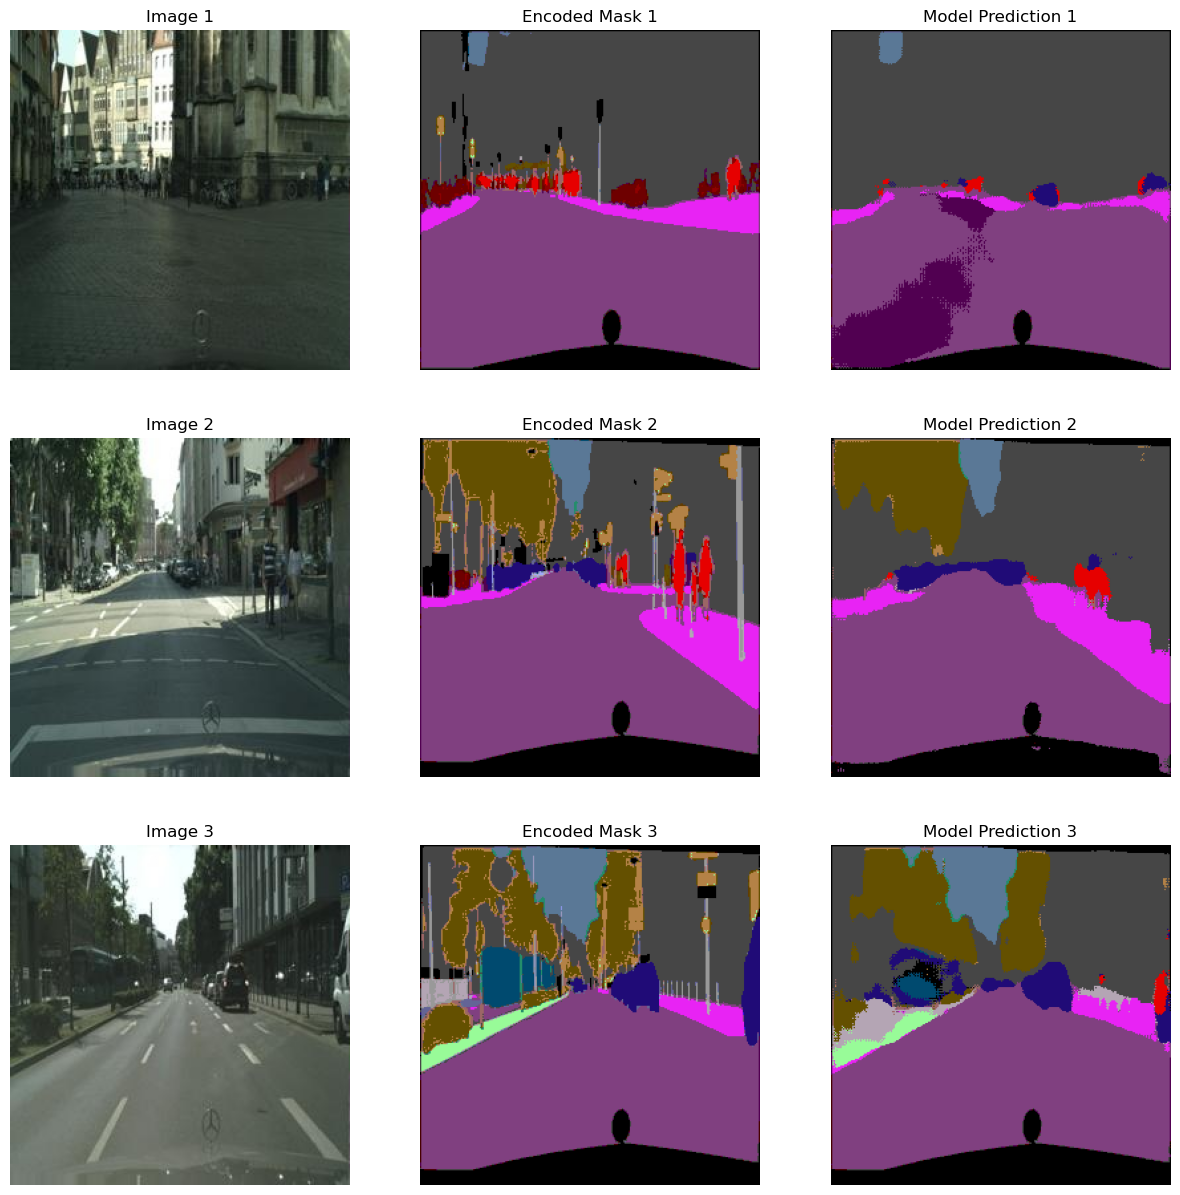

In [33]:
num = 3
plt.figure(figsize=[15, 5*num])

for i in range(num):
    n = 2*i+1
    #Load image and its mask
    image = X_val[n]
    mask = Y_val_enc[n]
    #Find predicted mask
    pred = UNet.predict(image.reshape([1,256,256,3]))
    
    #Remove the starting dimension
    pred = np.squeeze(pred, axis=0)
    
    #For each pixel, find the index of class with highest value
    pred_max = np.argmax(pred, axis=-1)
    
    #Color according to Id2Color
    pred_color = np.zeros_like(image)
    for row in range(256):
        for col in range(256):
            class_id = pred_max[row, col]
            color = Id2Color[class_id]
            pred_color[row, col] = color
    
    pred_color = pred_color.astype(np.uint8)
    
    #Plot all 3
    plt.subplot(num, 3, i*3 + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(num, 3, i*3 + 2)
    plt.imshow(cv2.cvtColor(color_enc_mask(mask,Id2Color), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(num, 3, i*3 + 3)
    plt.imshow(cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))